In [3]:
%matplotlib inline
import boto3
import botocore
import datetime
import matplotlib.pyplot as plt
import os.path
import os
import xarray as xr
import numpy as np
import pandas as pd

In [2]:
era5_bucket = 'era5-pds'

# AWS access / secret keys required
# s3 = boto3.resource('s3')
# bucket = s3.Bucket(era5_bucket)

# No AWS keys required
client = boto3.client('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED))

In [3]:
var1='northward_wind_at_10_metres'
var2='eastward_wind_at_10_metres'

In [4]:
years = list(range(2000, 2021))
months = ["{:02d}".format(n) for n in range(1, 13)]

In [7]:
s3_data_ptrn = '{year}/{month}/data/{var}.nc'
data_file_ptrn = 'era5/temp/{year}{month}_{var}.nc'


data_east = xr.Dataset()
data_north = xr.Dataset()

for year in years:
    for month in months:
        s3_data_key_east = s3_data_ptrn.format(year=year, month=month, var=var2)
        data_file_east = data_file_ptrn.format(year=year, month=month, var=var2)
        if not os.path.isfile(data_file_east): # check if file already exists
            print("Downloading %s from S3..." % s3_data_key_east)
            client.download_file(era5_bucket, s3_data_key_east, data_file_east)
        data_east = xr.combine_by_coords([data_east, xr.open_dataset(data_file_east).sel(lat=slice(25, 5), lon=slice(60, 80))])
        os.remove(data_file_east)

        s3_data_key_north = s3_data_ptrn.format(year=year, month=month, var=var1)
        data_file_north = data_file_ptrn.format(year=year, month=month, var=var1)
        if not os.path.isfile(data_file_north): # check if file already exists
            print("Downloading %s from S3..." % s3_data_key_north)
            client.download_file(era5_bucket, s3_data_key_north, data_file_north)
        data_north = xr.combine_by_coords([data_north, xr.open_dataset(data_file_north).sel(lat=slice(25, 5), lon=slice(60, 80))])
        os.remove(data_file_north)
 

In [18]:
keys = []
date = datetime.date(2021,1,1) # update to desired date
prefix = date.strftime('%Y/%m/')

response = client.list_objects_v2(Bucket=era5_bucket, Prefix=prefix)
response_meta = response.get('ResponseMetadata')

data = xr.Dataset()
if response_meta.get('HTTPStatusCode') == 200:
    contents = response.get('Contents')
    if contents == None:
        print("No objects are available for %s" % date.strftime('%B, %Y'))
    else:
        for obj in contents:
            keys.append(obj.get('Key'))
        print("There are %s objects available for %s\n--" % (len(keys), date.strftime('%B, %Y')))
        for k in keys:
            print(k)
else:
    print("There was an error with your request.")

There are 19 objects available for January, 2021
--
2021/01/data/air_pressure_at_mean_sea_level.nc
2021/01/data/air_temperature_at_2_metres.nc
2021/01/data/air_temperature_at_2_metres_1hour_Maximum.nc
2021/01/data/air_temperature_at_2_metres_1hour_Minimum.nc
2021/01/data/dew_point_temperature_at_2_metres.nc
2021/01/data/eastward_wind_at_100_metres.nc
2021/01/data/eastward_wind_at_10_metres.nc
2021/01/data/integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation.nc
2021/01/data/lwe_thickness_of_surface_snow_amount.nc
2021/01/data/northward_wind_at_100_metres.nc
2021/01/data/northward_wind_at_10_metres.nc
2021/01/data/precipitation_amount_1hour_Accumulation.nc
2021/01/data/sea_surface_temperature.nc
2021/01/data/sea_surface_wave_from_direction.nc
2021/01/data/sea_surface_wave_mean_period.nc
2021/01/data/significant_height_of_wind_and_swell_waves.nc
2021/01/data/snow_density.nc
2021/01/data/surface_air_pressure.nc
2021/01/main.nc


In [47]:
f200701 = xr.open_dataset('era5/200701_eastward_wind_at_10_metres.nc')

In [14]:
xr.open_dataset('era5/200001_northward_wind_at_10_metres.nc').sel(lon=slice(60, 80), lat=slice(25, 5))

<xarray.Dataset>
Dimensions:                      (lon: 81, lat: 81, time0: 744)
Coordinates:
  * lon                          (lon) float32 60.0 60.25 60.5 ... 79.75 80.0
  * lat                          (lat) float32 25.0 24.75 24.5 ... 5.5 5.25 5.0
  * time0                        (time0) datetime64[ns] 2000-01-01 ... 2000-0...
Data variables:
    northward_wind_at_10_metres  (time0, lat, lon) float32 ...
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    tilte:        ERA5 forecasts

In [8]:
data_east

<xarray.Dataset>
Dimensions:                     (lon: 81, lat: 81, time0: 184104)
Coordinates:
  * lon                         (lon) float32 60.0 60.25 60.5 ... 79.75 80.0
  * lat                         (lat) float32 25.0 24.75 24.5 ... 5.5 5.25 5.0
  * time0                       (time0) datetime64[ns] 2000-01-01 ... 2020-12...
Data variables:
    eastward_wind_at_10_metres  (time0, lat, lon) float32 -1.728 ... -5.688
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    tilte:        ERA5 forecasts
    title:        ERA5 forecasts

In [9]:
data_north

<xarray.Dataset>
Dimensions:                      (lon: 81, lat: 81, time0: 184104)
Coordinates:
  * lon                          (lon) float32 60.0 60.25 60.5 ... 79.75 80.0
  * lat                          (lat) float32 25.0 24.75 24.5 ... 5.5 5.25 5.0
  * time0                        (time0) datetime64[ns] 2000-01-01 ... 2020-1...
Data variables:
    northward_wind_at_10_metres  (time0, lat, lon) float32 -1.07 ... -3.188
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    tilte:        ERA5 forecasts
    title:        ERA5 forecasts

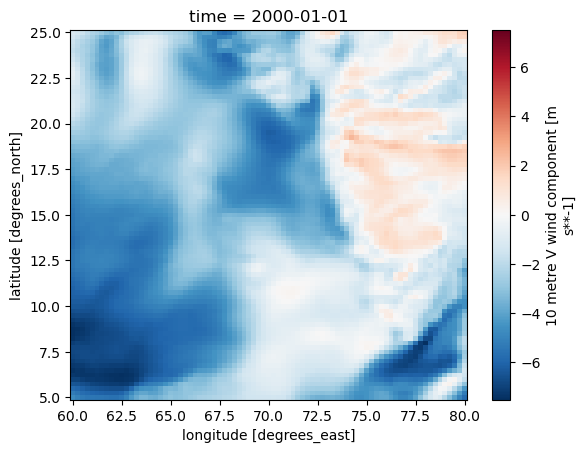

In [21]:
data_north['v_wind'].isel(time=0).plot.imshow()

In [10]:
data_north = data_north.rename({'time0':'time', 'northward_wind_at_10_metres': 'v_wind'})

In [11]:
data_east = data_east.rename({'time0':'time', 'eastward_wind_at_10_metres': 'u_wind'})

In [1]:
wind_reanalysis = xr.combine_by_coords([data_north, data_east])

NameError: name 'xr' is not defined

In [ ]:
wind_reanalysis.to_netcdf('wind.nc')

In [78]:
wind_reanalysis = wind_reanalysis.rename_vars({'eastward_wind_at_10_metres': 'u_wind', 'northward_wind_at_10_metres':'v_wind'})

In [16]:
w = wind_reanalysis.resample(time='12H').mean()

# Open dataset

In [4]:
wind = xr.open_dataset('era5/wind_12h_avg.nc')

In [5]:
wind

<xarray.Dataset>
Dimensions:  (lon: 81, lat: 81, time: 15342)
Coordinates:
  * lon      (lon) float32 60.0 60.25 60.5 60.75 61.0 ... 79.25 79.5 79.75 80.0
  * lat      (lat) float32 25.0 24.75 24.5 24.25 24.0 ... 6.0 5.75 5.5 5.25 5.0
  * time     (time) datetime64[ns] 2000-01-01 ... 2020-12-31T12:00:00
Data variables:
    u_wind   (time, lat, lon) float32 ...
    v_wind   (time, lat, lon) float32 ...
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    tilte:        ERA5 forecasts
    title:        ERA5 forecasts

In [13]:
wind =wind.assign(speed=np.sqrt(wind.u_wind**2+wind.v_wind**2))
wind = wind.assign(direction=np.rad2deg(np.arctan2(wind.v_wind, wind.u_wind)))
wind.to_netcdf('era5/wind_avg_12h_processed.nc')

In [30]:
ind = pd.read_csv('era5/india_bounds.csv')

In [14]:
i = wind.isel(time=0)['speed'].plot

matplotlib.image.AxesImage

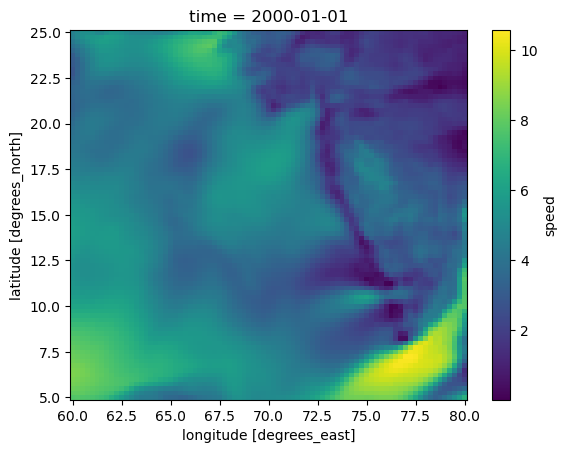

In [17]:
type(i.imshow())

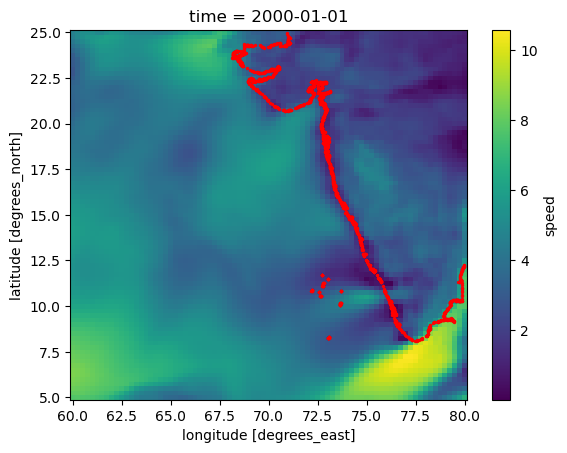

In [32]:
i.imshow()
plt.scatter(ind['x'], ind['y'], c='red', s = 2)

# Masking

In [46]:
# only applies to dataset with lon,lat, and time coordinates

def mask_array(dataset, lon_var_name='lon', lat_var_name='lat'):
    mask = pd.read_csv('mask.csv')
    flag = mask.assign(flag=1).set_index(["lat", "lon"]).flag.to_xarray().fillna(0).rename({'lat': lat_var_name, 'lon': lon_var_name})
    flag_reindex = flag.reindex(lon=dataset[lon_var_name], lat=ex[lat_var_name], method='nearest', tolerance=1e-2, fill_value=0)
    return dataset.where(flag_reindex)


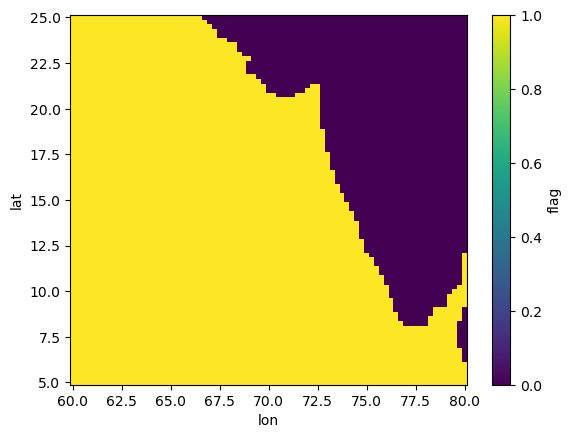

In [25]:
flag.plot.imshow()

In [29]:
ex = wind.u_wind.isel(time=0)

In [43]:
flag_reindex_1 = flag.reindex(lon=wind.lon, lat=wind.lat, method='nearest', tolerance=1e-2, fill_value=0)
flag_reindex_1

<xarray.DataArray 'flag' (lat: 81, lon: 81)>
array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])
Coordinates:
  * lon      (lon) float32 60.0 60.25 60.5 60.75 61.0 ... 79.25 79.5 79.75 80.0
  * lat      (lat) float32 25.0 24.75 24.5 24.25 24.0 ... 6.0 5.75 5.5 5.25 5.0

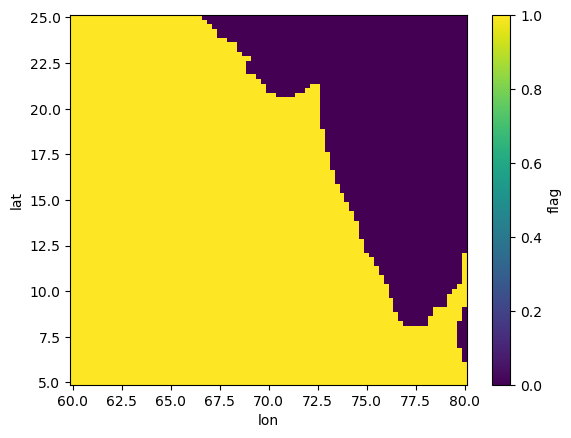

In [44]:
flag_reindex.plot.imshow()

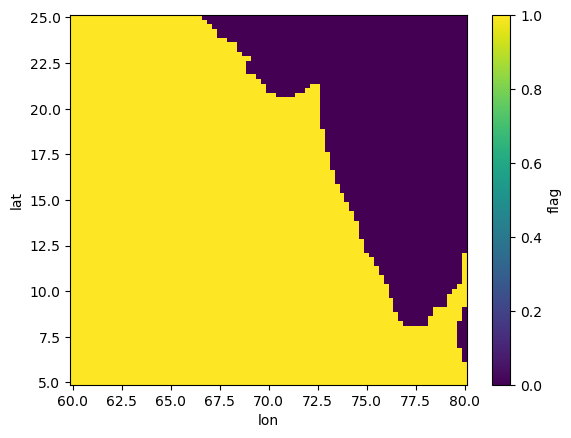

In [45]:
flag_reindex_1.plot.imshow()

In [35]:
wind_masked = wind.where(flag_reindex)

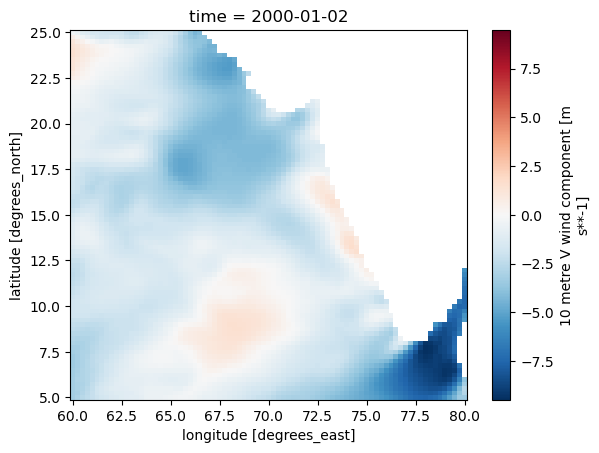

In [37]:
wind_masked.isel(time=2)['v_wind'].plot.imshow()

In [40]:
wind_masked= wind_masked.assign(speed=np.sqrt(wind_masked.u_wind**2+wind_masked.v_wind**2))
wind_masked = wind_masked.assign(direction=np.rad2deg(np.arctan2(wind_masked.v_wind, wind_masked.u_wind)))
wind_masked.to_netcdf('era5/wind_avg_12h_processed.nc')

In [41]:
wind_masked

<xarray.Dataset>
Dimensions:    (time: 15342, lat: 81, lon: 81)
Coordinates:
  * lon        (lon) float32 60.0 60.25 60.5 60.75 ... 79.25 79.5 79.75 80.0
  * lat        (lat) float32 25.0 24.75 24.5 24.25 24.0 ... 5.75 5.5 5.25 5.0
  * time       (time) datetime64[ns] 2000-01-01 ... 2020-12-31T12:00:00
Data variables:
    u_wind     (time, lat, lon) float32 -4.615 -4.889 -5.186 ... -6.365 -6.531
    v_wind     (time, lat, lon) float32 -0.1133 -0.3022 ... -2.354 -2.552
    speed      (time, lat, lon) float32 4.616 4.898 5.217 ... 6.416 6.786 7.012
    direction  (time, lat, lon) float32 -178.6 -176.5 -173.8 ... -159.7 -158.7
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    tilte:        ERA5 forecasts
    title:        ERA5 forecasts

In [ ]:
wind_masked = wind